# OCR
Note: not implemented because couldn't get PyTesseract to work

In [1]:
from PIL import Image
import pytesseract
import numpy as np

# Image Recognition
Caveats: ensure there are no New tags. Also, image recognition for talent books may be tough

In [39]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import sys
from datetime import datetime
import os
import json
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras import Model
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [107]:
image = Image.open("raw data/6.png").convert('RGB')
image = np.asarray(image, dtype=np.float32) / 255.0

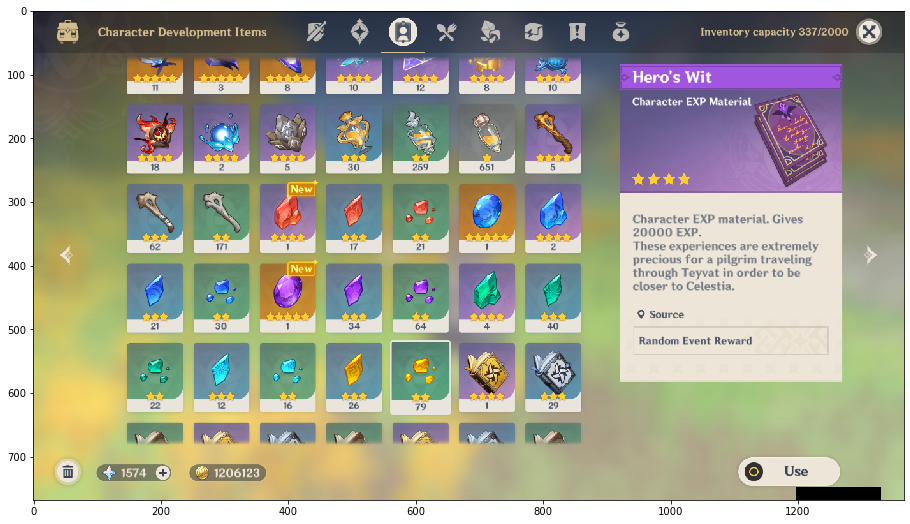

In [108]:
fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(image)

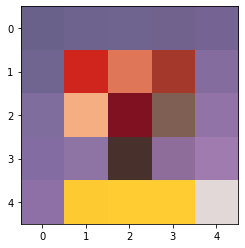

In [110]:
resized_image = cv2.resize(image, (80, 45))
x = 9
y = 9
plt.imshow(resized_image[x:x+5,y:y+5,:])

In [112]:
label_dict = {
    (9,9) : "everflame_seed",
    (9,15) : "cleansing_heart",
    (9,21) : "juvenile_jade",
    (9,27) : "nectar_2",
    (9,33) : "nectar_1",
    (9,39) : "nectar_0",
    (9,45) : "bone_shard_2",
    (16,9) : "bone_shard_1",
    (16,15) : "bone_shard_0",
    (16,21) : "to_delete",
    (16,27) : "agnidus_agate_1",
    (16,33) : "agnidus_agate_0",
    (16,39) : "varunada_lazurite_3",
    (16,45) : "varunada_lazurite_2",
    (23,9) : "varunada_lazurite_1",
    (23,15) : "varunada_lazurite_0",
    (23,21) : "to_delete",
    (23,27) : "vajrada_amethyst_1",
    (23,33) : "vajrada_amethyst_0",
    (23,39) : "vayuda_turqoise_2",
    (23,45) : "vayuda_turqoise_1",
    (31,9) : "vayuda_turqoise_0",
    (31,15) : "shivada_jade_1",
    (31,21) : "shivada_jade_0",
    (31,27) : "prithiva_topaz_1",
    (31,33) : "prithiva_topaz_0",
    (31,39) : "freedom_2",
    (31,45) : "freedom_1"
}

In [113]:
from IPython.display import clear_output
try:
    labels = pd.read_csv("train labels.csv", index=False)
except:
    labels = pd.DataFrame(columns=["filename", "label"])

resized_image = cv2.resize(image, (80, 45))
train_folder = "train data/"
starting_index = len(os.listdir("train data/"))

for j in range(75):
    for i in range(40):
        filename = str(starting_index) + ".jpg"
        label = label_dict.get((i,j),"none")
        if label == "to_delete":
            continue
        labels = labels.append({"filename":filename,"label":label}, ignore_index=True)
        im = Image.fromarray((resized_image[i:i+5,j:j+5,:] * 255).astype(np.uint8))
        im.save(train_folder + filename)
        starting_index += 1
labels.to_csv("train labels.csv", index=False)

# Making the network

In [5]:
def make_network(input_shape):
    model = Sequential([
        Input(shape=input_shape, name="input"),
        Conv2D(64, 3, data_format="channels_last", activation="relu",
               name="conv", input_shape=input_shape),
        Flatten(name="flatten"),
        Dense(units=25, activation=relu, name="dense"),
        Dense(133, activation=softmax, name="output")
    ])
    return Model(inputs=model.inputs, 
                 outputs=model.get_layer(name="output").output, 
                 name="Genshin_Recogniser")

image_recogniser = make_network((5,5,3))
image_recogniser.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
image_recogniser.summary()

Model: "Genshin_Recogniser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5, 5, 3)]         0         
_________________________________________________________________
conv (Conv2D)                (None, 3, 3, 64)          1792      
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 25)                14425     
_________________________________________________________________
output (Dense)               (None, 133)               3458      
Total params: 19,675
Trainable params: 19,675
Non-trainable params: 0
_________________________________________________________________


In [154]:
data = pd.read_csv("train labels.csv")
item_labels = json.loads(open("item_labels.json").read())
images = []
labels = []
train_folder = "train data/"

for row in data.iterrows():
    filename = train_folder + row[1]["filename"]
    image = Image.open(filename).convert('RGB')
    image = np.asarray(image, dtype=np.float32) / 255.0
    images.append(image)
    label = int(item_labels[row[1]["label"]])
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)

In [155]:
history = image_recogniser.fit(x=images, y=labels, batch_size=64, 
                               epochs=200, verbose=0, shuffle=True)

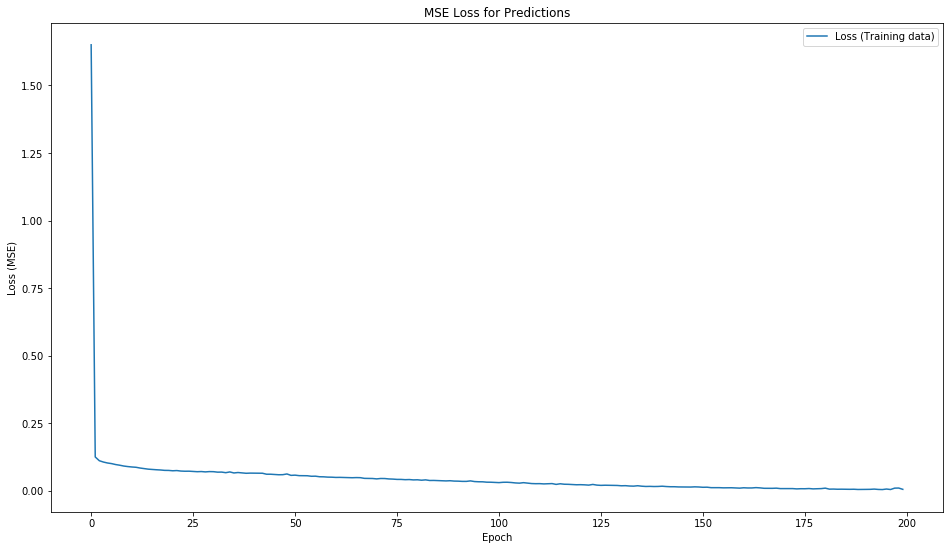

In [157]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'], label='Loss (Training data)')
plt.title('MSE Loss for Predictions')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [160]:
np.argmax(image_recogniser.predict(images[5].reshape((1,5,5,3))))

0